In [1]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import collections
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

# k-means
from sklearn.cluster import KMeans

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

#Funkcionalnost implementirana u V1
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def image_bin_adaptive(image_gs):
    image_bin = cv2.adaptiveThreshold(image_gs, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 10)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

#Funkcionalnost implementirana u V2
def resize_region(region):
    resized = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

def remove_noise(binary_image):
    ret_val = erode(erode(dilate(binary_image)))
    ret_val = invert(ret_val)
    return ret_val


In [7]:
def select_roi(image_orig, image_bin):
    '''Oznaciti regione od interesa na originalnoj slici. (ROI = regions of interest)
        Za svaki region napraviti posebnu sliku dimenzija 28 x 28. 
        Za označavanje regiona koristiti metodu cv2.boundingRect(contour).
        Kao povratnu vrednost vratiti originalnu sliku na kojoj su obeleženi regioni
        i niz slika koje predstavljaju regione sortirane po rastućoj vrednosti x ose
    '''
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po x osi (sa leva na desno)
    regions_dic = {}
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour) #koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        if area > 100 and h < 100 and h > 15 and w > 20:
            region=image_bin[y:y+h+1, x:x+w+1]
            regions_dic[x]=resize_region(region)
            cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),2)
            # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
            # označiti region pravougaonikom na originalnoj slici (image_orig) sa rectangle funkcijom
    # sortirati sve regione po x osi (sa leva na desno) i smestiti u promenljivu sorted_regions
    sorted_regions_dic = collections.OrderedDict(sorted(regions_dic.items()))
    sorted_regions = sorted_regions_dic.values()                                      
    return image_orig, sorted_regions

In [4]:
def create_ann():
    '''
    Implementirati veštačku neuronsku mrežu sa 28x28 ulaznih neurona i jednim skrivenim slojem od 128 neurona.
    Odrediti broj izlaznih neurona. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    # Postaviti slojeve neurona mreže 'ann'
    ann.add(Dense(128, input_dim=28 * 28, activation='sigmoid'))
    ann.add(Dense(14, activation='sigmoid'))
    return ann
    
def train_ann(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=500, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

In [5]:
def display_result(outputs, alphabet):
    '''za svaki rezultat pronaći indeks pobedničkog
        regiona koji ujedno predstavlja i indeks u alfabetu.
        Dodati karakter iz alfabet u result'''
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

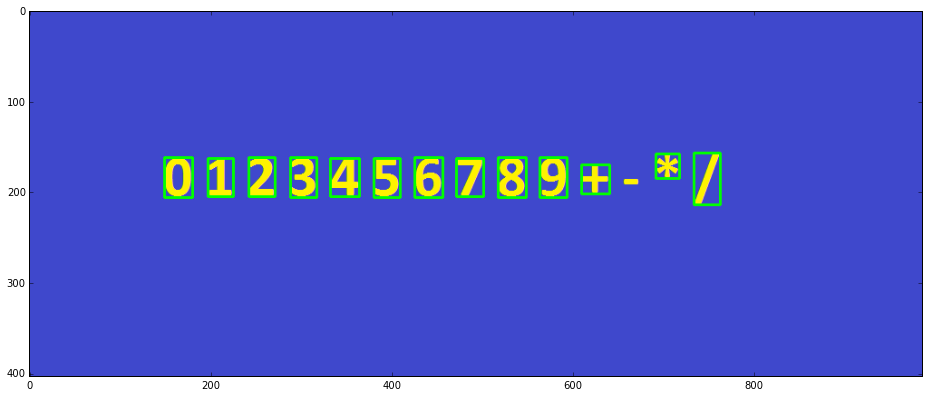

In [8]:
#START
image_color = load_image('kalkulator_alfabet.png')
img = invert(image_bin(image_gray(image_color)))
img_bin = erode(dilate(img))
selected_regions, numbers = select_roi(image_color.copy(), img)
display_image(selected_regions)

In [14]:
# insert alphabet here
alphabet = [0,1,2,3,4,5,6,7,8,9,'*','/','-','+']

inputs = prepare_for_ann(numbers)
outputs = convert_output(alphabet)
ann = create_ann()
ann = train_ann(ann, inputs, outputs)

In [15]:
result = ann.predict(np.array(inputs, np.float32))
print display_result(result, alphabet)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, '*', '/', '-']
